# Pre-Processing Pipeline for Character Trajectories Dataset  

## Overview

This notebook contains the code for importing the raw CharacterTrajectories dataset and preparing it for use with a torchcde, LSTM, and RNN implementation.

In [67]:
import os
from sktime.datasets import load_from_tsfile_to_dataframe
import numpy as np
import torch

# Load the data
train_X, train_y = load_from_tsfile_to_dataframe('../../../data/raw/char_traj/CharacterTrajectories_TRAIN.ts')
test_X, test_y = load_from_tsfile_to_dataframe('../../../data/raw/char_traj/CharacterTrajectories_TEST.ts')

# Convert to NumPy arrays
train_X = train_X.to_numpy()
test_X = test_X.to_numpy()

# Concatenate the data to form a single dataset
X = np.concatenate((train_X, test_X), axis=0)   # (batch, channel)
y = np.concatenate((train_y, test_y), axis=0)   # (batch,)

# Change the labels to start from 0 and be integers
classes = np.unique(y)
y = np.array([np.where(classes == yi)[0][0] for yi in y])

# Make y a tensor
y = torch.tensor(y)

In [68]:
def _pad(channel, maxlen):
    channel = torch.tensor(channel)
    out = torch.full((maxlen,), 0, dtype=channel.dtype)
    out[:channel.size(0)] = channel
    return out

# Pad all data to same size with zeros. To be corrected for torchcde
lengths = torch.tensor([len(Xi[0]) for Xi in X])
maxlen = lengths.max()

X = torch.stack([torch.stack([_pad(channel, maxlen) for channel in batch], dim=0) for batch in X], dim=0)
X = X.transpose(-1, -2)

In [69]:
# Add time as a channel
times = [np.linspace(0, lengths[i] - 1, lengths[i]) for i in range(len(X))]
for i, time in enumerate(times):
    padding = np.zeros(maxlen - len(time))
    times[i] = np.concatenate((time, padding))

times = torch.tensor(times)

X = torch.cat((times.unsqueeze(-1), X), dim=-1)

In [70]:
def create_labels(X, lengths, split_ratio=0.7):
    '''
    Create labels for the data based on the split_ratio parameter.
    The data is the first split_ratio of each sequence and the labels
    are the remaining (1 - split_ratio) part. Sequences are padded
    with zeros to be the same length.

    Parameters
    ----------
    X : torch.Tensor
        The data of shape (batch, seq_length, channels).
    lengths : torch.Tensor
        The lengths of the sequences.
    split_ratio : float, optional
        The ratio to split the sequences into data and labels. Default is 0.7.

    Returns
    -------
    data : torch.Tensor
        The data of shape (batch, seq_length * split_ratio, channels).
    labels : torch.Tensor
        The labels of shape (batch, seq_length * (1 - split_ratio), channels).
    '''
    data = torch.zeros(X.size(0), int(X.size(1) * split_ratio), X.size(2))
    labels = torch.zeros(X.size(0), X.size(1) - int(X.size(1) * split_ratio), X.size(2))

    for i in range(X.size(0)):
        # Pad datapoint with zeros
        datapoint = X[i, :int(lengths[i] * split_ratio)]
        padding = torch.zeros(int(X.size(1) * split_ratio) - len(datapoint), X.size(2))
        datapoint = torch.cat((datapoint, padding))

        # Pad label with zeros
        label = X[i, int(lengths[i] * split_ratio):lengths[i]]
        padding = torch.zeros(int(X.size(1) * (1 - split_ratio)) + 1 - len(label), X.size(2))
        label = torch.cat((label, padding))
        
        data[i] = datapoint
        labels[i] = label

    return data, labels

X, y = create_labels(X, lengths)

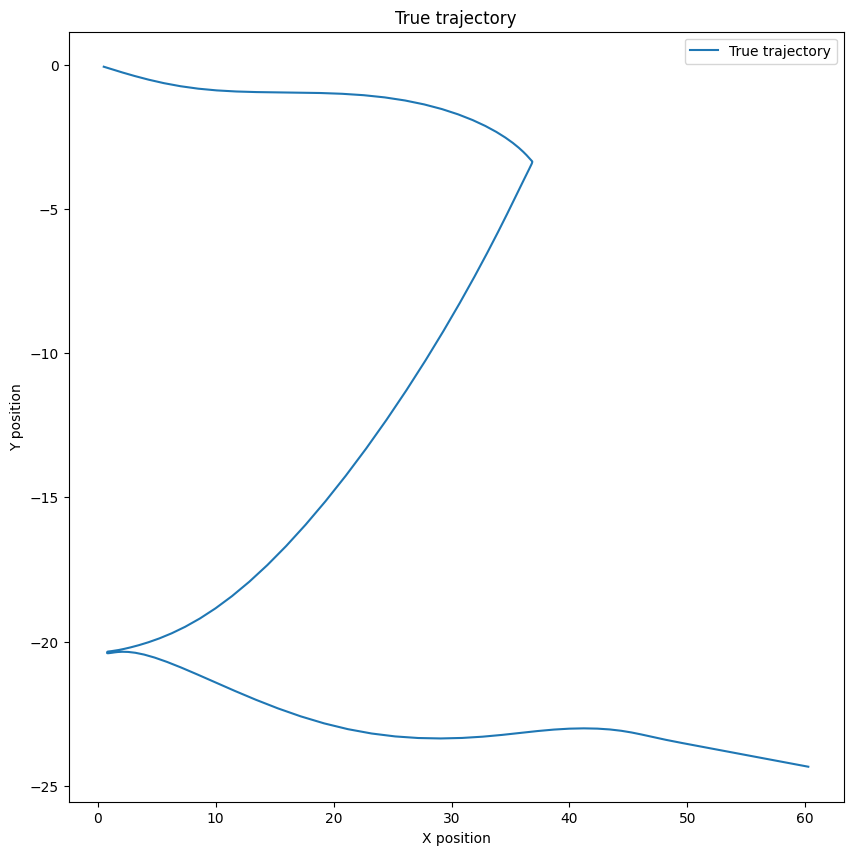

In [71]:
import matplotlib.pyplot as plt

def plot_true_trajectory(X, y, id):
    X = X[id]
    y = y[id]

    X = X[:, 1:]
    y = y[:, 1:]

    X = torch.cat([X, y], dim=0)
    
    x_velocity = X[:, 0]
    y_velocity = X[:, 1]

    x_position = torch.cumsum(x_velocity, dim=0)
    y_position = torch.cumsum(y_velocity, dim=0)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.plot(x_position, y_position, label='True trajectory')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title('True trajectory')
    plt.legend()
    
    # Show the plot
    plt.show()

plot_true_trajectory(data, labels, 2857)

In [72]:
# Split the data into train and test
np.random.seed(0)

indices = np.arange(len(X))
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

test_size = 0.2
num_test = int(test_size * len(X))

X_train, X_test = X_shuffled[:-num_test], X_shuffled[-num_test:]
y_train, y_test = y_shuffled[:-num_test], y_shuffled[-num_test:]

# Save the data
path = '../../../data/processed/CharacterTrajectories/regression'
os.makedirs(path, exist_ok=True)
torch.save(X_train, os.path.join(path, 'X_train.pt'))
torch.save(y_train, os.path.join(path, 'y_train.pt'))
torch.save(X_test, os.path.join(path, 'X_test.pt'))
torch.save(y_test, os.path.join(path, 'y_test.pt'))